In [3]:
# Imports
import os
import numpy as np
import pandas as pd

In [4]:
# Expect the file to be in the same folder as this notebook
df = pd.read_csv('retentiondata_case.csv' )
print(df.shape)
print(df.describe(include='all'))
#print(df['Outcome'].value_counts())# summary stats
#missing_counts = df.isnull().sum()
#missing_counts

(5636, 36)
          acct_ref      cust_ref has_dependents    tenure_mo home_phone  \
count         5636          5636           5636  5636.000000       5636   
unique        5621          5636              2          NaN          2   
top     ACCT940714  CUST61880322             No          NaN        Yes   
freq             2             1           3957          NaN       5079   
mean           NaN           NaN            NaN    32.445174        NaN   
std            NaN           NaN            NaN    24.515986        NaN   
min            NaN           NaN            NaN     0.000000        NaN   
25%            NaN           NaN            NaN     9.000000        NaN   
50%            NaN           NaN            NaN    29.000000        NaN   
75%            NaN           NaN            NaN    55.000000        NaN   
max            NaN           NaN            NaN    72.000000        NaN   

       multi_line internet_plan add_on_security add_on_backup  \
count        5636      

In [5]:
### For classification problems, first determine the classes of your response variable
print(df["left_flag"].dtype)                     # what type is it? 
print(df["left_flag"].unique())                  # list of unique classes in the response variable

df["left_flag"] = df["left_flag"].str.strip().str.lower().map({"yes": 1, "no": 0})

object
['No' 'Yes']


In [7]:
Y = (df["left_flag"] == 1).astype(int) # returns True for rows where response == 1 and False otherwise then .astype(int) converts True→1 and False→0, so the “positive” label becomes 1
X = df.drop(columns=["left_flag","acct_ref", "cust_ref"]) 

In [8]:
from sklearn.model_selection import train_test_split

# Split into train/test sets
X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y, 
    test_size=0.3,     # 30% test, 70% train
    random_state=99,   # reproducibility
    shuffle=True       # shuffle before splitting
)

# Check shapes
X_train.shape, X_test.shape

((3945, 33), (1691, 33))

In [9]:
# Needed for preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder


# Identify column types from TRAIN ONLY
num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X_train.select_dtypes(exclude=["number"]).columns.tolist()

# Build preprocessing (train-only learning happens during .fit())
# numeric variable imputation
numeric_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="mean"))
])

#categorical variable imputation
categorical_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="warn", sparse_output=False))  
])

#Aplpy the preprocessing to numeric and categorical variables
preprocess = ColumnTransformer([
    ("num", numeric_pipe, num_cols),
    ("cat", categorical_pipe, cat_cols)
])

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
#!pip install xgboost if not installed
from xgboost import XGBClassifier


# Stratified CV preserves class balance in each fold (important for classification)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)


# Pipeline with XGBoost model
xgb_pipe = Pipeline([
    ("preprocess", preprocess),
    ("model", XGBClassifier(
        objective="binary:logistic",
        n_jobs=2,          # use all cores
        eval_metric="auc",  # pairs well with scoring="roc_auc"
        tree_method="hist", # fast CPU histogram algorithm (use "gpu_hist" if you have a GPU)
        random_state=99
    ))
])

#  Hyperparameter grid (more parameters here: https://federated-xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn)
param_grid = {
    "model__n_estimators": [400, 800],
    "model__max_depth":    [4, 6, 8],
    "model__learning_rate":[0.05, 0.1],
    "model__subsample":    [0.8, 1.0],
    "model__colsample_bytree": [0.8, 1.0],
    "model__min_child_weight": [1, 3]
}

#  Cross-validated grid search (same scoring)
xgb_cv = GridSearchCV(
    estimator=xgb_pipe,
    param_grid=param_grid,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1,
    refit=True
)

# Fit 
xgb_cv.fit(X_train, Y_train)


print("Best params selected by CV:", xgb_cv.best_params_)
print("Best CV ROC-AUC:", round(xgb_cv.best_score_, 3))

Best params selected by CV: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.05, 'model__max_depth': 4, 'model__min_child_weight': 1, 'model__n_estimators': 400, 'model__subsample': 1.0}
Best CV ROC-AUC: 0.898


In [11]:
help (XGBClassifier)

Help on class XGBClassifier in module xgboost.sklearn:

class XGBClassifier(sklearn.base.ClassifierMixin, XGBModel)
 |  XGBClassifier(
 |      *,
 |      objective: Union[str, xgboost.sklearn._SklObjWProto, Callable[[Any, Any], Tuple[numpy.ndarray, numpy.ndarray]], NoneType] = 'binary:logistic',
 |      **kwargs: Any
 |  ) -> None
 |
 |  Implementation of the scikit-learn API for XGBoost classification.
 |  See :doc:`/python/sklearn_estimator` for more information.
 |
 |  Parameters
 |  ----------
 |
 |      n_estimators : Optional[int]
 |          Number of boosting rounds.
 |
 |      max_depth :  typing.Optional[int]
 |
 |          Maximum tree depth for base learners.
 |
 |      max_leaves : typing.Optional[int]
 |
 |          Maximum number of leaves; 0 indicates no limit.
 |
 |      max_bin : typing.Optional[int]
 |
 |          If using histogram-based algorithm, maximum number of bins per feature
 |
 |      grow_policy : typing.Optional[str]
 |
 |          Tree growing policy.
 |

cat__contract_term_Month-to-month    0.152093
cat__internet_plan_Fiber optic       0.115946
cat__tech_support_std_No             0.049604
cat__add_on_security_No              0.045753
cat__contract_term_Two year          0.043726
num__referrals_count                 0.043633
cat__has_dependents_No               0.040874
cat__has_dependents_Yes              0.034984
num__dependents_count                0.031230
cat__pay_method_Electronic check     0.021137
dtype: float32

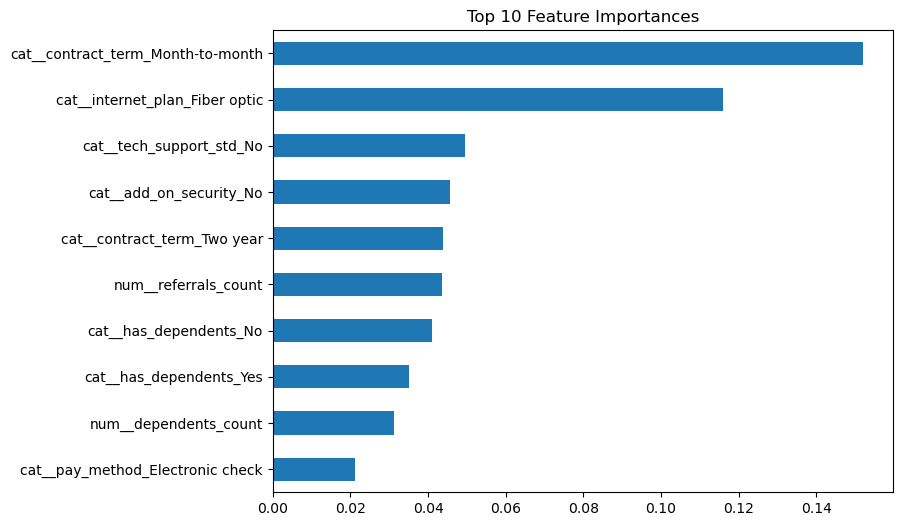

In [12]:
# Get best fitted model from GridSearchCV
best_xgb = xgb_cv.best_estimator_.named_steps["model"]

#get important features
pre = xgb_cv.best_estimator_.named_steps["preprocess"]
feature_names = pre.get_feature_names_out()
imp = pd.Series(best_xgb.feature_importances_, index=feature_names).sort_values(ascending=False)

display(imp.head(10))  # top 10 features


# Optional: plot top features
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
imp.head(10).plot(kind="barh", x="feature", y="importance", legend=False)
plt.title("Top 10 Feature Importances")
plt.gca().invert_yaxis()
plt.show()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 554.9/554.9 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [shap]


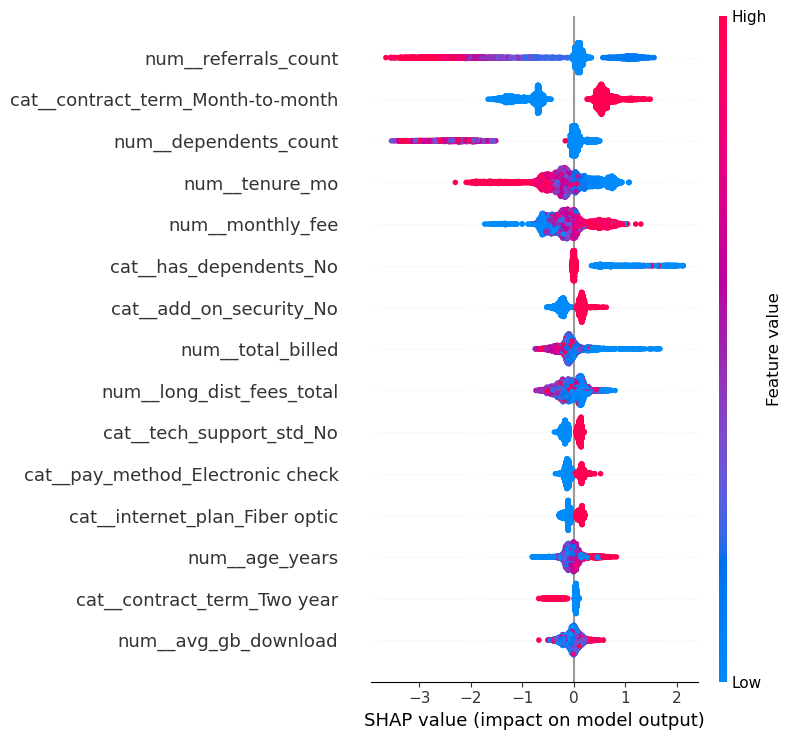

In [18]:
!pip install shap   # Install SHAP library if not already installed
import shap                  

pre = xgb_cv.best_estimator_.named_steps["preprocess"]

#  Transform X the same way the model saw it
X_train_enc = pre.transform(X_train)

#  Get feature names after preprocessing (works for ColumnTransformer / Pipeline in sklearn >= 1.0)
feature_names = None
if hasattr(pre, "get_feature_names_out"):
    feature_names = pre.get_feature_names_out()
    
# Create SHAP explainer for tree-based models (e.g., XGBoost, LightGBM, RandomForest)
explainer   = shap.TreeExplainer(best_xgb)

# Compute SHAP values for the training set
# Each value shows how much a feature pushes a prediction toward class 1 (positive) or class 0 (negative)
shap_values = explainer.shap_values(X_train_enc)

# Overall PLot Beeswarm plot: this shows both which features matter most and the direction of their influence

shap.summary_plot(shap_values, X_train_enc, max_display=15, show=True,feature_names=feature_names)

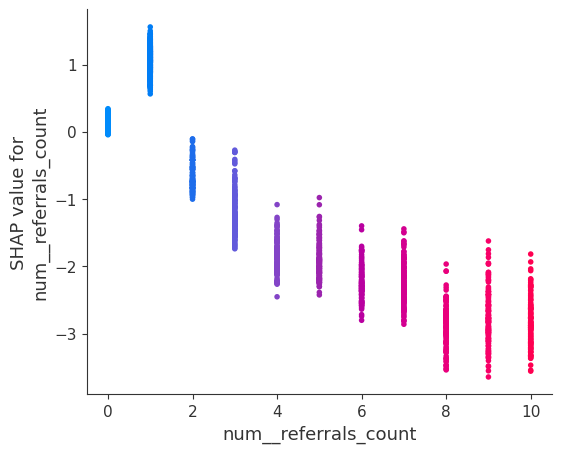

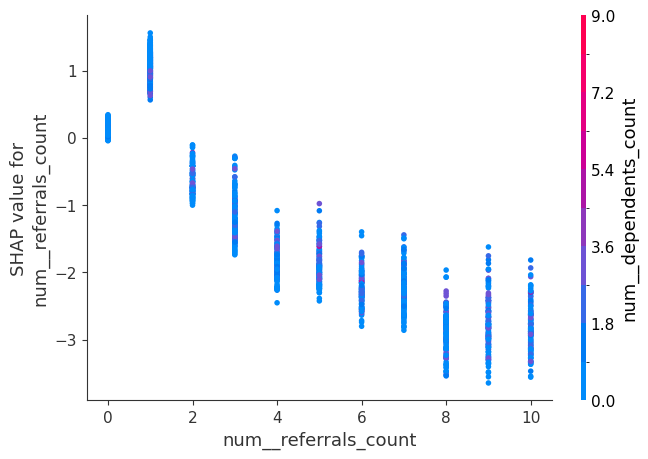

In [21]:
#Dependence plot for one feature
shap.dependence_plot("num__referrals_count", shap_values, X_train_enc, interaction_index="num__referrals_count", show=True,feature_names=feature_names)

# Dependence plot for one feature, colored by another feature
shap.dependence_plot("num__referrals_count", shap_values, X_train_enc, interaction_index="num__dependents_count",  show=True,feature_names=feature_names)

In [22]:
Ytest_prob = xgb_cv.predict_proba(X_test)[:, 1]

Test ROC-AUC: 0.8988


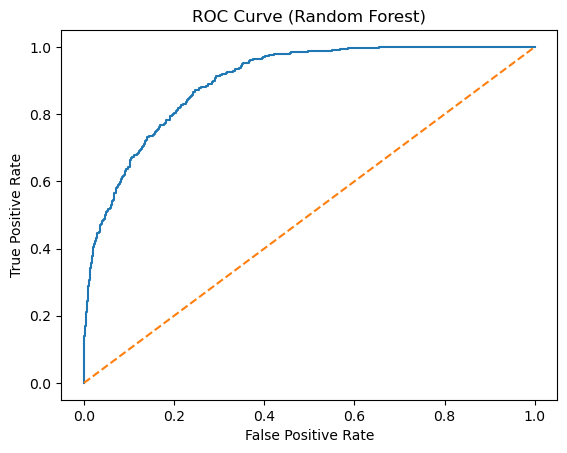

In [23]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt  

test_auc = roc_auc_score(Y_test, Ytest_prob)
print("Test ROC-AUC:", round(test_auc, 4))

# ROC curve (single plot; no custom colors)
fpr, tpr, _ = roc_curve(Y_test, Ytest_prob)
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Random Forest)")
plt.show()